# Structure learning of sampled data 

## Load 1000 samples generated from Student performance Bayesian network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyAgrum as gum
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as explain
import pyAgrum.lib.bn_vs_bn as bnvsbn

pd.set_option('display.max_rows', 15)

# load dataset
df = pd.read_csv("datasets/sampled_student_prediction.csv")
df

,A,D,G,ST1,J,ST2,S,T,E,H,P,Att,R,L
0,18-21,sometimes,fail,alone,no,last moment,male,sometimes,no,None,high school,always,yes,rental
1,18-21,always,pass,alone,no,last moment,male,sometimes,no,6-10 hours,university,always,no,dormitory
2,22-25,sometimes,pass,alone,no,regularly,female,always,no,<5 hours,high school,always,no,dormitory
3,22-25,always,pass,alone,no,last moment,male,always,no,<5 hours,high school,always,yes,rental
4,18-21,sometimes,pass,alone,yes,last moment,male,always,no,None,high school,sometimes,no,with family
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,22-25,sometimes,pass,alone,no,last moment,male,sometimes,yes,<5 hours,university,always,no,dormitory
996,22-25,always,fail,not applicable,no,last moment,male,always,no,<5 hours,MSc.,always,yes,dormitory
997,18-21,always,pass,with friends,yes,last moment,male,always,no,None,university,always,yes,dormitory
998,22-25,always,fail,alone,no,last moment,female,always,no,<5 hours,secondary school,sometimes,yes,rental


## Load target BN

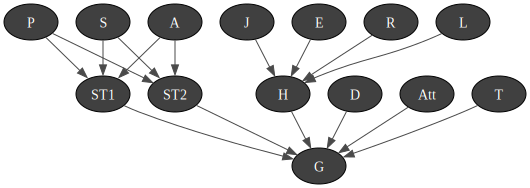

In [3]:
# load target structure 
bn_target = gum.loadBN("student_performance_BN.xdsl")
gnb.showBN(bn_target, size=20)

## Create template BN with the same variables as target

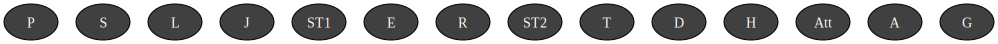

In [4]:
temp = gum.BayesNet("Structure learning - Student Performance network")

for name in bn_target.names():
    temp.add(bn_target.variableFromName(name))

gnb.showBN(temp, size=20)

## Analysis
evaluation metrics: 
- structural hamming distance (SHD)
- Euclidean distance
- Balanced Scoring Function (BSF) 

### Based on metrics

In [202]:
get_arcs = lambda bn: {(bn.variable(f).name(), bn.variable(t).name()) for (f, t) in bn.arcs()}

N = bn_target.size()

hamming_ghc = []
skeleton_ghc = []
bsf_ghc = []

for size in range(1, 1000):
    learner_ghc = gum.BNLearner(df.sample(size), temp)
    learner_ghc.useGreedyHillClimbing()
    bn = learner_ghc.learnBN()

    cmp = bnvsbn.GraphicalBNComparator(bn_target, bn)
    skeleton_scores = cmp.skeletonScores()
    skeleton_ghc.append(skeleton_scores)
    hamming_ghc.append(cmp.hamming()["structural hamming"])

    cm = skeleton_scores["count"]
    present_edges = len(get_arcs(bn).intersection(get_arcs(bn_target)))
    absent_edges  = (N * (N-1))/2 - present_edges
    if absent_edges == 0 or present_edges == 0: continue
    bsf = (cm["tp"]/present_edges + 
           cm["tn"]/absent_edges + 
           cm["fp"]/absent_edges + 
           cm["fn"]/present_edges)/2
    bsf_ghc.append([size, bsf])

hamming_miic = []
skeleton_miic = []
bsf_miic = []

for size in range(1, 1000):
    learner_ghc = gum.BNLearner(df.sample(size), temp)
    learner_ghc.useMIIC()
    bn = learner_ghc.learnBN()
    
    cmp = bnvsbn.GraphicalBNComparator(bn_target, bn)
    skeleton_scores = cmp.skeletonScores()
    skeleton_miic.append(skeleton_scores)
    hamming_miic.append(cmp.hamming()["structural hamming"])

    cm = skeleton_scores["count"]
    present_edges = len(get_arcs(bn).intersection(get_arcs(bn_target)))
    absent_edges  = (N * (N-1))/2 - present_edges
    if absent_edges == 0 or present_edges == 0: continue
    bsf = (cm["tp"]/present_edges + 
           cm["tn"]/absent_edges + 
           cm["fp"]/absent_edges + 
           cm["fn"]/present_edges)/2
    bsf_miic.append([size, bsf])


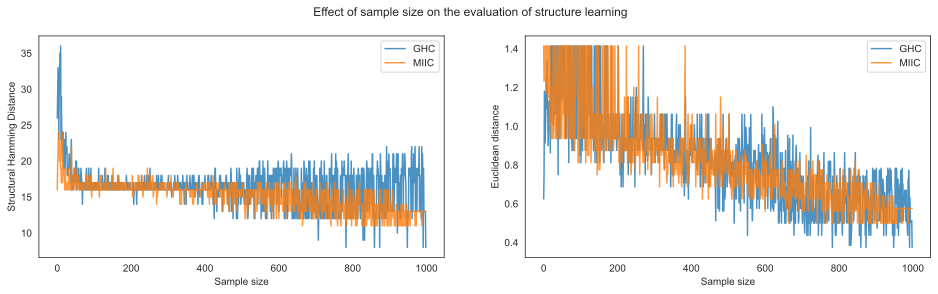

In [215]:
extract_dict_member = lambda d, key: list(map(lambda x: x[key], d))

dist_miic = extract_dict_member(skeleton_miic, "dist2opt")
dist_ghc = extract_dict_member(skeleton_ghc, "dist2opt")

figs, axes = plt.subplots(1, 2, figsize=(16, 4))

plt.suptitle("Effect of sample size on the evaluation of structure learning")
axes[0].plot(hamming_ghc,  label="GHC" , alpha=0.8)
axes[0].plot(hamming_miic, label="MIIC", alpha=0.8)
axes[0].set_xlabel("Sample size")
axes[0].set_ylabel("Structural Hamming Distance")
axes[0].legend()

axes[1].plot(dist_ghc,  label="GHC" , alpha=0.8)
axes[1].plot(dist_miic, label="MIIC", alpha=0.8)
axes[1].set_xlabel("Sample size")
axes[1].set_ylabel("Euclidean distance")
axes[1].legend()
plt.show()

In [204]:
bsf_ghc_np = np.array(bsf_ghc)
bsf_miic_np = np.array(bsf_miic)

df_bsf_miic = pd.concat([
    pd.DataFrame(bsf_miic_np, columns=["Sample size", "Balanced Scoring Function"]), 
    pd.Series(bsf_miic_np.shape[0] * ["MIIC"], name="Algorithm")], axis=1)
bsf_ghc_np = pd.concat([
    pd.DataFrame(bsf_ghc_np, columns=["Sample size", "Balanced Scoring Function"]), 
    pd.Series(bsf_ghc_np.shape[0] * ["GHC"], name="Algorithm")], axis=1)

merged_bsf = pd.concat([bsf_ghc_np, df_bsf_miic])

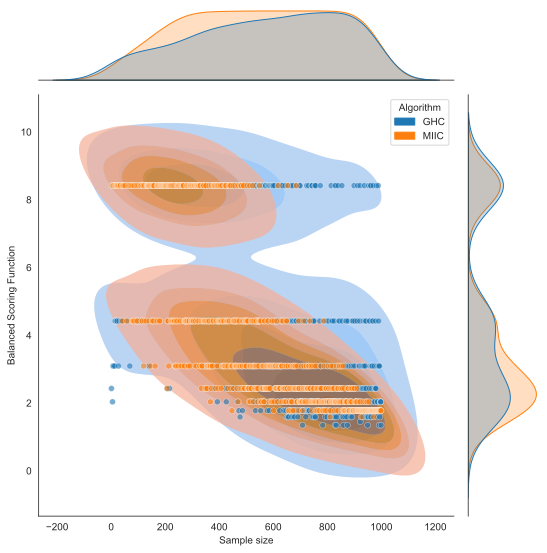

In [205]:
sns.reset_defaults()
sns.set_style("white")

g = sns.jointplot(data=merged_bsf, x="Sample size", y="Balanced Scoring Function", hue="Algorithm", kind="scatter", alpha=0.6)
g.fig.set_size_inches((8, 8))
g.plot_joint(sns.kdeplot, color="Reds", zorder=0, levels=6, fill=True, alpha=0.7)
plt.show()

### Evaluate structure of 100, 500, 1000 samples based on graph and metrics

In [5]:
sample_sizes = [100, 500, 1000]
bns_ghc = []
bns_miic = []

for size in sample_sizes:
    learner_ghc = gum.BNLearner(df.sample(size), temp)
    learner_ghc.useGreedyHillClimbing()
    bns_ghc.append(learner_ghc.learnBN())

for size in sample_sizes:
    learner_miic = gum.BNLearner(df.sample(size), temp)
    learner_miic.useMIIC()
    bns_miic.append(learner_miic.learnBN())


In [6]:
gnb.flow.row(*bns_ghc, captions=[f"sample size: {x}" for x in sample_sizes])

In [7]:
gnb.flow.row(*bns_miic, captions=[f"sample size: {x}" for x in sample_sizes])

In [10]:
gnb.flow.add(bnvsbn.graphDiff(bns_miic[2], bn_target), "MIIC difference between learnt and target with 1000 samples")
gnb.flow.add(bnvsbn.graphDiff(bns_ghc[2], bn_target), "GHC difference between learnt and target with 1000 samples")
gnb.flow.add(bnvsbn.graphDiffLegend(), "Legend")

gnb.flow.html()

In [15]:
f = open("./html_images/bn_diff.html", "w")
f.write(gnb.flow.sHtml)
f.close()

### Compute mean scores for 100, 500, 1000 samples 

In [210]:
from collections import defaultdict

def evaluate_structure(learner, bn_cmp_to):
       N = bn_target.size()
       bn = learner.learnBN()

       cmp = bnvsbn.GraphicalBNComparator(bn_cmp_to, bn)
       skeleton_scores = cmp.skeletonScores()

       shd = cmp.hamming()["structural hamming"]
       dist2bn = skeleton_scores["dist2opt"]
       cm = skeleton_scores["count"]
       present_edges = len(get_arcs(bn).intersection(get_arcs(bn_cmp_to)))
       absent_edges  = (N * (N-1))/2 - present_edges
       if absent_edges == 0 or present_edges == 0: return (shd, dist2bn, None)
       bsf = (cm["tp"]/present_edges + 
              cm["tn"]/absent_edges + 
              cm["fp"]/absent_edges + 
              cm["fn"]/present_edges)/2
       return (shd, dist2bn, bsf)

sizes = [100, 500, 1000]
ITERS = 200

ghc_eval = defaultdict(dict)
miic_eval = defaultdict(dict)

for size in sizes:
       shds, eds, bsfs = [], [], []
       for _ in range(ITERS):
              df_target_sample = gum.generateSample(bn_target, size)[0]
              learner = gum.BNLearner(df_target_sample, temp)
              learner.useGreedyHillClimbing()
              (shd, ed, bsf) = evaluate_structure(learner, bn_target)
              shds.append(shd)
              eds.append(ed)
              if bsf: bsfs.append(bsf)

       np_shds = np.array(shds)
       ghc_eval[size]["SHD"] = (np_shds.mean(), np_shds.std())
       np_eds = np.array(eds)
       ghc_eval[size]["ED"] = (np_eds.mean(), np_eds.std())
       np_bsfs = np.array(bsfs)
       ghc_eval[size]["BSF"] = (np_bsfs.mean(), np_bsfs.std())

       shds, eds, bsfs = [], [], []
       for _ in range(ITERS):
              df_target_sample = gum.generateSample(bn_target, size)[0]
              learner = gum.BNLearner(df_target_sample, temp)
              learner.useMIIC()
              (shd, ed, bsf) = evaluate_structure(learner, bn_target)
              shds.append(shd)
              eds.append(ed)
              if bsf: bsfs.append(bsf)

       np_shds = np.array(shds)
       miic_eval[size]["SHD"] = (np_shds.mean(), np_shds.std())
       np_eds = np.array(eds)
       miic_eval[size]["ED"] = (np_eds.mean(), np_eds.std())
       np_bsfs = np.array(bsfs)
       miic_eval[size]["BSF"] = (np_bsfs.mean(), np_bsfs.std())



In [211]:
ghc_eval

defaultdict(dict,
            {100: {'SHD': (16.66, 0.9297311439335567),
              'ED': (1.1280020951737404, 0.2227356441793131),
              'BSF': (7.293084239515946, 1.8567883780622036)},
             500: {'SHD': (16.485, 1.802713232879817),
              'ED': (0.7991229348989313, 0.1111251611335966),
              'BSF': (5.160656491810467, 2.5162732278047764)},
             1000: {'SHD': (15.815, 4.228566541985593),
              'ED': (0.6079869300325079, 0.12308597251490279),
              'BSF': (2.8513955220088003, 1.6193009607924065)}})

In [212]:
miic_eval

defaultdict(dict,
            {100: {'SHD': (16.595, 0.9439147207242823),
              'ED': (1.212696874196315, 0.23206550573787776),
              'BSF': (7.32484002168136, 1.9004928799618743)},
             500: {'SHD': (14.745, 1.4142047235107087),
              'ED': (0.7748077303905123, 0.08942984669779651),
              'BSF': (3.554558234320642, 1.7710228586014969)},
             1000: {'SHD': (12.045, 1.470705612962703),
              'ED': (0.5829659379049016, 0.08628830992046677),
              'BSF': (1.8852166999541264, 0.29538538554386695)}})